# Read and analyze case 6126 E08 (Ajia) - 4   [ correlation, co-location ]

**BMED320: Methods in biomedical research (IMC-ML)  / 2020-12-06**<br>


Using data from Damond et al. A Map of Human Type 1 Diabetes Progression by Imaging Mass Cytometry. Cell Metabolism 2019;29(3):755-768.e5<br>
See: https://github.com/arvidl/BMED320-imaging-mass-cytometry-ml/blob/master/notebooks/imc-case-damond-2019/README.md


## Progression by Imaging Mass Cytometry

Published: 09-04-2020  **Version 2**  **DOI**:10.17632/cydmwsfztj.2  [[link](https://data.mendeley.com/datasets/cydmwsfztj/2)]<br>
Contributor: Nicolas Damond

### Description
Data related to the publication: "A Map of Human Type 1 Diabetes Progression by Imaging Mass Cytometry".

Damond N, Engler S, Zanotelli VRT, Schapiro D, Wasserfall CH, Kusmartseva I, Nick HS, Thorel F, Herrera PL, Atkinson MA and Bodenmiller B. Cell Metab. 2019 Mar 5;29(3):755-768.e5. https://doi.org/10.1016/j.cmet.2018.11.014

We used imaging mass cytometry to simultaneously image 37 biomarkers with single-cell and spatial resolution in pancreas sections from 12 human donors at different stages of type 1 diabetes.
```shell
CODE:
- Python script for coordinate transformation
- Functions for custom histoCAT neighborhood analysis

DATA:
- Single-cell data
- Islet-level data
- Cell type information
- Cell relationships (cell-cell neighborhoods and cell-islet relationships)
- Donors and image metadata.
- Subset containing the data for 100 images from 3 donors

IMAGES:
- Image stacks (37 channels) for all donors (one .7z file per donor, numbers indicate nPOD case IDs)
- Cell masks
- Panel file with information related to antibodies and metal tags
- Metadata file linking donor information to images
- Metadata file linking image stack slices and panel information
- Subset containing 100 images from 3 donors
```


- Downloads --> cydmwsfztj-1 --> Data --> Images -->  Panel.csv (1 KB) / Metadata.csv (25 KB) / 6126.7z (360 MB)

- 6126.7z (360 MB) --> E08_a0_full.csv (222 B) / E08_a0_full.tiff (42 MB)

| **image**	 | **case**	| **slide**	 | **part**	| **group** |	**stage**  |
| :--------: | :------: | :--------: | :------: | :-------: | :---------:  |
|   E08	     | 6126	    | E	         | Tail	    |       1   | Non-diabetic |

**E08_a0_full.csv**: 
In113
In115
Pr141
Nd142
Nd143
Nd144
Nd145
Nd146
Sm147
Nd148
Sm149
Nd150
Sm152
Eu153
Sm154
Gd156
Gd158
Tb159
Gd160
Dy161
Dy162
Dy163
Dy164
Ho165
Er166
Er167
Er168
Tm169
Er170
Yb171
Yb172
Yb173
Yb174
Lu175
Yb176
Ir191
Ir193

### Import the libraries being used

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from skimage import io
from skimage import color
from skimage import morphology
from skimage.morphology import disk
from skimage.filters import median
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import ndimage
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte
from skimage import img_as_float
from scipy.ndimage import gaussian_filter
from skimage.morphology import reconstruction
import nibabel as nib
import os
home = os.path.expanduser('~')  # To make path to local home directory
import tifffile as tiff
from pycaret.clustering import *

### Define the data being used

In [3]:
fn_tiff = './data/E08_a0_full.tiff'
fn_csv = './data/E08_a0_full.csv'
fn_panel = './data/table1_IMC_panel_37x4.csv'

# For direct inclusion of figures and tables in the Overleaf on Linux / MacOS and NOT Windows ('nt')
# i.e. LaTeX document (Overleaf is synced with Dropbox on MacOS/Linux)
if os.name == 'nt':
    fn_fig_base = '%s/tmp' % home
    fn_tab_base = '%s/tmp' % home
else:    
    fn_fig_base = '%s/Dropbox/Apps/Overleaf/Imaging_Mass_Cytometry_and_Machine_Learning_BMED320_project2020/Figs' % (home)
    fn_tab_base = '%s/Dropbox/Apps/Overleaf/Imaging_Mass_Cytometry_and_Machine_Learning_BMED320_project2020' % (home)

### Read the IMC imagefile and print characteristics

In [4]:
im = io.imread(fn_tiff)
print(type(im))
print(im.shape)

<class 'numpy.ndarray'>
(37, 530, 567)


### Get number of channels in the recording

In [5]:
n_chn = im.shape[0]
n_chn

37

### Read the Panel file and channel numbering into a Pandas dataframe

!! In the original data, there was an nconsistency in Panel vs. IMC channel list (175Yb vs. Lu175) !!

In [6]:
fn = './data/E08_a0_panel_data_and_channel_numbering.csv'
df_p = pd.read_csv(fn)
print(df_p.shape)
df_p

(37, 5)


,Short Name,Antigen,Main Target Cells,Metal Tag,Chn
0,INS,Insulin,β,141Pr,3
1,PIN,Proinsulin,β,154Sm,15
2,GCG,Glucagon,α,156Gd,16
3,SST,Somatostatin,δ,159Tb,18
4,PPY,Pancreatic polypeptide,γ,153Eu,14
5,NKX6-1,Homeobox protein Nkx-6.1,β,169Tm,28
6,PDX1,Pancreatic and duodenal homeobox 1,β δ ductal,158Gd,17
7,IAPP,Amylin,β,167Er,26
8,PCSK2,Proprotein convertase 2,α,144Nd,6
9,SYP,Synaptophysin,Endocrine,160Gd,19


In [7]:
df_p_sort_chn = df_p.sort_values('Chn')
df_p_sort_chn

,Short Name,Antigen,Main Target Cells,Metal Tag,Chn
34,H3,Histone H3,Nuclei,113In,1
28,SMA,Smooth muscle actin,Stromal,115In,2
0,INS,Insulin,β,141Pr,3
25,CD38,CD38,Immune,142Nd,4
15,CD44,CD44,Exocrine,143Nd,5
8,PCSK2,Proprotein convertase 2,α,144Nd,6
10,CD99,CD99,Endocrine,145Nd,7
22,CD68,CD68,Monocytes macrophages,146Nd,8
23,MPO,Myeloperoxidase,Neutrophils,147Sm,9
11,SLC2A1,Glucose transporter 1,Endocrine,148Nd,10


### Plot the IMC dataset as a 7 x 6 grid of color-coded channels (and save Fig for the Overleaf document)

With histogram equalization for better visualization
https://stackoverflow.com/questions/28518684/histogram-equalization-of-grayscale-images-with-numpy

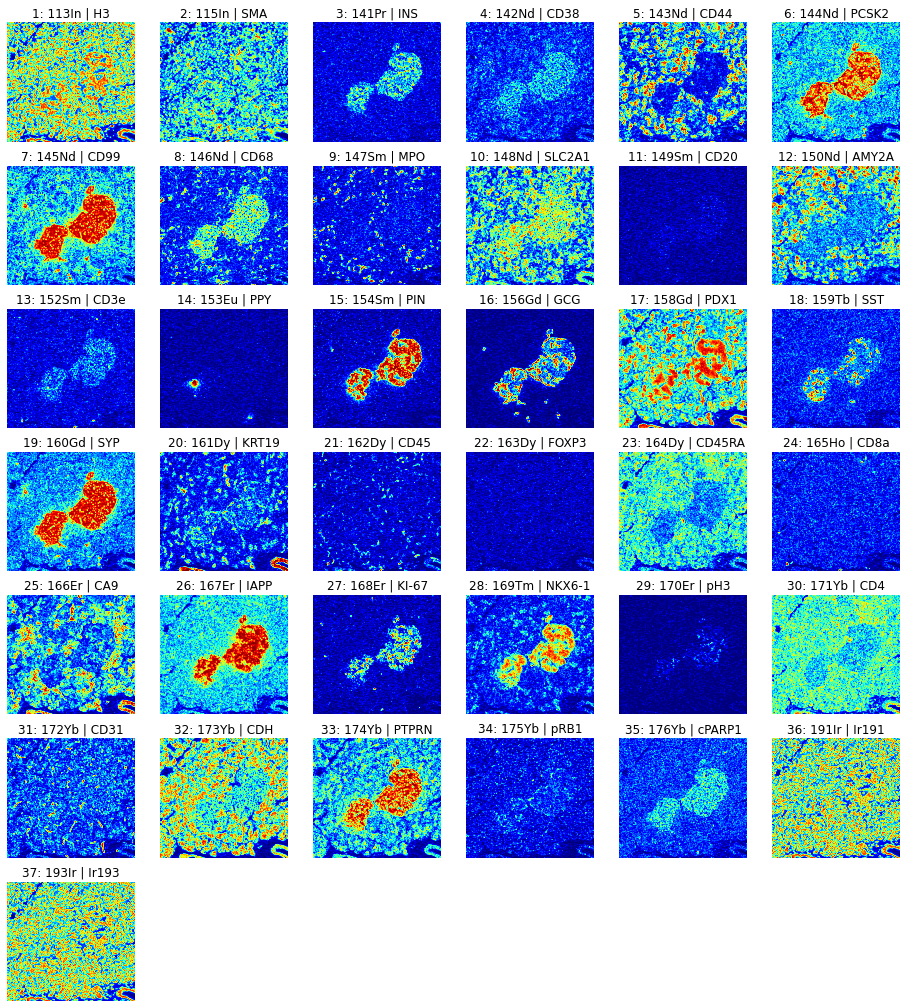

In [8]:
fig_fn = '%s/BMED320_experiments_case6126_E08_channel_eq_mosaic_jet.pdf' % fn_fig_base
fig, axes = plt.subplots(7, 6, figsize=(16, 18), sharex=False, sharey=False)
ax = axes.ravel()
for i, item in enumerate(range(n_chn)):
    chn = np.squeeze(im[i,:,:])
    chn_eq = np.sort(chn.ravel()).searchsorted(chn)  # a kind of histogram equalization
    ax[i].imshow(chn_eq, cmap='jet' )   # cmap='jet', 'gray'
    ax[i].set_title('%d: %s | %s' % ((i+1), df_p_sort_chn['Metal Tag'].iloc[i], df_p_sort_chn['Short Name'].iloc[i]))
    ax[i].axis('off')
chn_0 = np.zeros(chn.shape )   
for j in range(n_chn,7*6):
    ax[j].imshow(chn_0, cmap='gray_r') 
    ax[j].axis('off')
# plt.savefig(fig_fn, bbox_inches='tight')
plt.show()

## Read IMC .csv files into a Pandas dataframe 

In [9]:
dfIMC_fn = './data/BMED320_experiments_case6126_E08_CyTOF_pixels.csv'
dfIMC = pd.read_csv(dfIMC_fn)
dfIMC.columns

Index(['113In', '115In', '141Pr', '142Nd', '143Nd', '144Nd', '145Nd', '146Nd',
       '147Sm', '148Nd', '149Sm', '150Nd', '152Sm', '153Eu', '154Sm', '156Gd',
       '158Gd', '159Tb', '160Gd', '161Dy', '162Dy', '163Dy', '164Dy', '165Ho',
       '166Er', '167Er', '168Er', '169Tm', '170Er', '171Yb', '172Yb', '173Yb',
       '174Yb', '175Yb', '176Yb', '191Ir', '193Ir', 'row', 'col'],
      dtype='object')

In [10]:
inspect = pd.concat([dfIMC.head().T, dfIMC.tail().T], axis=1)
inspect

,0,1,2,3,4,300505,300506,300507,300508,300509
113In,1.066,11.754,18.484,15.564,19.813,14.342,30.667,29.274,23.422,16.829
115In,0.000,3.143,1.332,3.129,2.000,2.000,2.838,1.853,0.000,4.459
141Pr,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
142Nd,0.000,1.000,1.275,0.000,0.000,0.000,0.000,0.000,0.000,0.000
143Nd,12.395,8.871,3.000,1.000,0.000,0.000,0.000,0.000,1.029,0.000
144Nd,2.376,5.189,3.032,2.126,3.000,2.000,1.282,1.751,1.344,3.032
145Nd,1.000,0.000,0.000,1.912,0.000,0.000,0.000,2.413,0.000,0.000
146Nd,0.000,2.414,0.000,0.000,0.000,0.000,0.000,1.037,0.000,0.000
147Sm,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000
148Nd,4.537,6.969,4.158,0.000,0.000,0.000,0.000,0.000,3.779,0.000


In [11]:
dfIMCscaled_fn = './data/BMED320_experiments_case6126_E08_CyTOF_scaled_pixels.csv'
dfIMCscaled = pd.read_csv(dfIMCscaled_fn)
dfIMCscaled.columns

Index(['113In', '115In', '141Pr', '142Nd', '143Nd', '144Nd', '145Nd', '146Nd',
       '147Sm', '148Nd', '149Sm', '150Nd', '152Sm', '153Eu', '154Sm', '156Gd',
       '158Gd', '159Tb', '160Gd', '161Dy', '162Dy', '163Dy', '164Dy', '165Ho',
       '166Er', '167Er', '168Er', '169Tm', '170Er', '171Yb', '172Yb', '173Yb',
       '174Yb', '175Yb', '176Yb', '191Ir', '193Ir'],
      dtype='object')

In [12]:
inspect_scaled = pd.concat([dfIMCscaled.head().T, dfIMCscaled.tail().T], axis=1)
inspect_scaled

,0,1,2,3,4,300505,300506,300507,300508,300509
113In,-0.747246,0.324537,0.999415,0.706600,1.132686,0.584059,2.221116,2.081427,1.494594,0.833454
115In,-0.563615,1.171339,0.171656,1.163610,0.540396,0.540396,1.002977,0.459251,-0.563615,1.897778
141Pr,-0.334873,-0.334873,-0.334873,-0.334873,-0.334873,-0.334873,-0.334873,1.318977,-0.334873,-0.334873
142Nd,-0.442636,1.025362,1.429061,-0.442636,-0.442636,-0.442636,-0.442636,-0.442636,-0.442636,-0.442636
143Nd,3.811833,2.602732,0.588363,-0.097846,-0.440951,-0.440951,-0.440951,-0.440951,-0.087896,-0.440951
144Nd,0.059062,0.583768,0.181425,0.012429,0.175456,-0.011073,-0.145001,-0.057519,-0.133436,0.181425
145Nd,-0.325340,-0.423234,-0.423234,-0.236061,-0.423234,-0.423234,-0.423234,-0.187016,-0.423234,-0.423234
146Nd,-0.390886,1.438514,-0.390886,-0.390886,-0.390886,-0.390886,-0.390886,0.394983,-0.390886,-0.390886
147Sm,-0.179775,-0.179775,-0.179775,0.288491,-0.179775,-0.179775,-0.179775,-0.179775,-0.179775,-0.179775
148Nd,1.659931,2.911597,1.464873,-0.675106,-0.675106,-0.675106,-0.675106,-0.675106,1.269814,-0.675106


####  `scipy.stats.pearsonr`-  Calculates a Pearson correlation coefficient and the p-value for testing non-correlation

The Pearson correlation coefficient measures the linear relationship between two datasets. Strictly speaking, Pearson’s correlation requires that each dataset be normally distributed. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.

In [13]:
from scipy.stats.stats import pearsonr 

#v1 = '113In'  # '160Gd'
#v2 = '115In'  # '145Nd'
v1 = '160Gd'
v2 = '145Nd'
a = dfIMC[v1]
b = dfIMC[v2]
print(pearsonr(a,b))

(0.8300523748052645, 0.0)


In [14]:
#v1 = '113In'  # '160Gd'
#v2 = '115In'  # '145Nd'
v1 = '160Gd'
v2 = '145Nd'
a = dfIMCscaled[v1]
b = dfIMCscaled[v2]
print(pearsonr(a,b))

(0.8300523750367669, 0.0)


### Annotated heatmaps of a correlation matrix
cf. https://www.kdnuggets.com/2019/07/annotated-heatmaps-correlation-matrix.html

linewidth:  defines the size of the line between the boxes<br>
square: that will make the cells of our matrix in a square shape regardless of the size of the figure<br>
mask: there’s lots of redundancy in a correlation matrix; the upper triangle of the table has the same information as the lower,

In [15]:
dfIMCdata = dfIMC.copy()
dfIMCdata.drop(['row', 'col'], axis=1, inplace=True)

In [16]:
# method{‘pearson’, ‘kendall’, ‘spearman’} or callable

corr_matrix = dfIMCdata.corr(method='pearson')
print(corr_matrix.iloc[:2,:2])
# Set up mask to hide upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

# adjust mask and df
mask = mask[1:, :-1]
corr = corr_matrix.iloc[1:,:-1].copy()

          113In     115In
113In  1.000000  0.300407
115In  0.300407  1.000000


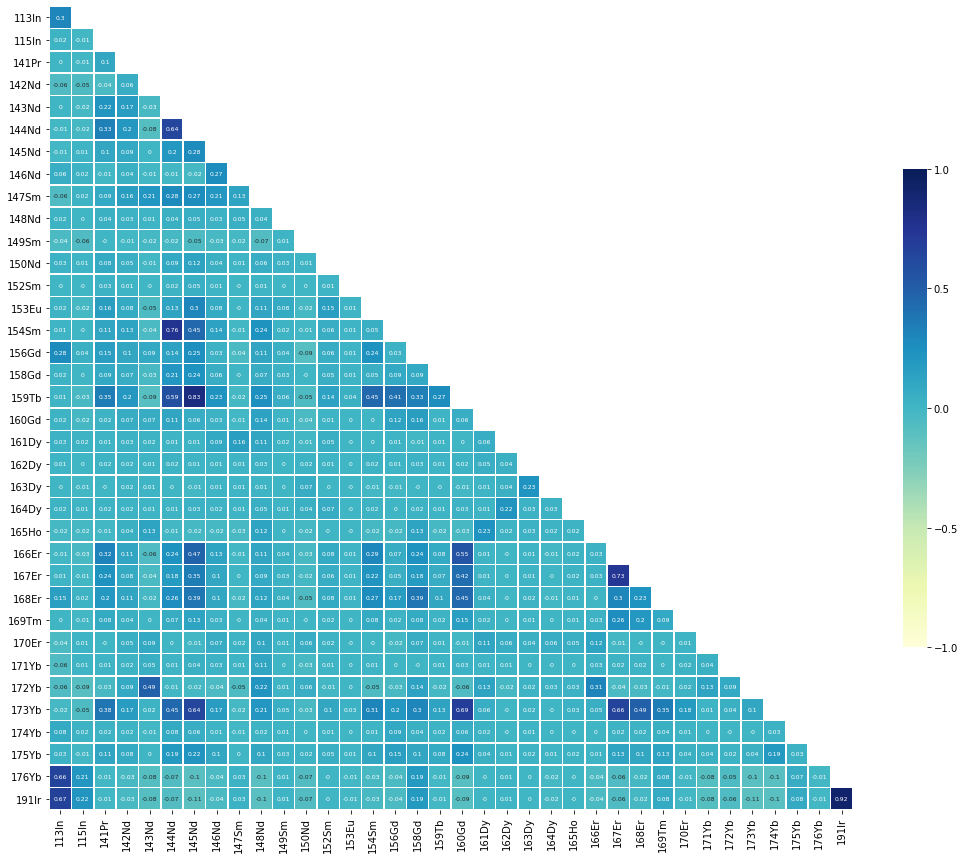

In [17]:
fig_fn = '%s/BMED320_experiments_case6126_E08_channel_pearson_correlation.pdf' % fn_fig_base

cmap = 'YlGnBu' 
#cmap = 'coolwarm'

f, ax = plt.subplots(figsize=(18, 22))

heatmap = sns.heatmap(corr.round(decimals=2),
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = cmap,
                      cbar_kws = {'shrink': .4,
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1,
                      vmax = 1,
                      annot = True,
                      annot_kws = {"size": 6})

#add the column names as labels
ax.set_yticklabels(corr.columns, rotation = 0)
ax.set_xticklabels(corr.columns)

sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
#heatmap.get_figure().savefig(‘heatmap.png’, bbox_inches=’tight’)

plt.savefig(fig_fn, bbox_inches='tight')

#### TO DO:  Check out co-localisation (simultaneous presence of Tag_a (i.e. > t_a) and Tag_b (i.e. > t_b) at a given location (i.e. pixel)
#### Co-localiozation maps ?
#### Targeted channels ?